In [2]:
#Group Number: 27
#Group Members: Luca Macesanu, Samik Singh, Carson Ngyuen, Mathew Huang

# Problem Statement

For our project, we wanted to create a model to play a videogame. During the process, we first considered playing pokemon. However, we were unable to find a robust dataset to use. Therefore, we ended up moving forward with the gym retro library where we were able to load games and create our own dataset. The game we wanted to choose was Mortal Kombat. However, that didn't work as we were unable to get it to run. Therefore, we settled on Super Mario Bros. Therefore, we decided to create models that would be able to complete world 1-1 of Super Mario Bros.


We first collected data. Then we moved on to using classification based approaches similar to what we learned in class. Lastly, we used Proximal Policy Optimization to expand upon our knowledge. 


# Data Collection


Since there were no existing datasets for our project, we decided to collect our own data. We collected a total of 128942 state action pairs in order to treat gameplay as a classification problem in order to predict how a human would play the game. 


Since we collected the data, data cleaning was more minimal. We remapped our action spaces as there were many action outputs that matched the state of the game. By consolidating these actions, we reduced the overall spread of our data. We also scaled the state space by normalizing pixel values making it easier to process as well. Lastly, we manually combed through the files removing corrupted or improperly recorded data

<histogram>

<np.mean the states>


In [12]:
#imports
import matplotlib.pyplot as plt

# Custom imports
from playback import get_state_action_pairs

In [13]:
def eliminate_unnecessary_action(data):
    action_space = data
    
    #This might not be necessary but im on a time crunch (Theres 100% a better way to do this)
    action_map = {
        64: 0,
        65: 1,
        66: 2,
        67: 3,
        128: 4,
        129: 5,
        130: 6,
        131: 7
    }
    
    # Map original action values to new values
    action_space = np.array([action_map.get(action, 0) for action in action_space])
    #print(action_space.size())
    
    return action_space

Adding  imitation_mario_rec_carson_032124_145619.npz
Adding  imitation_mario_rec_carson_032124_145652.npz
Adding  imitation_mario_rec_carson_032124_143622.npz


<BarContainer object of 8 artists>

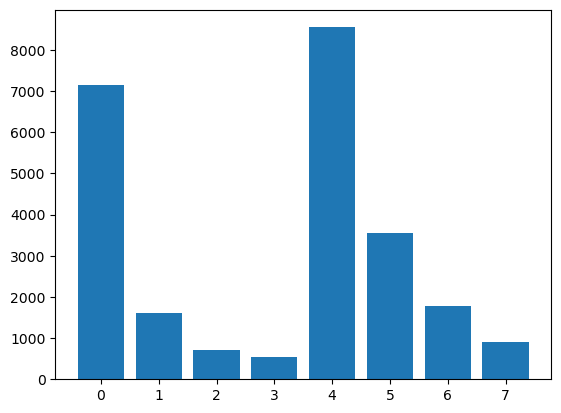

In [14]:
# generate bar chart of action frequencies
rec_state_history, rec_action_history = get_state_action_pairs(3)
#load data
rec_action_history = eliminate_unnecessary_action(rec_action_history)

unique_vals, frequencies = np. unique(rec_action_history, return_counts = True)
plt.bar(unique_vals, frequencies)

In [15]:
def average_images(images):
    average_image = np.mean(images, axis=0)
    plt.imshow(average_image, cmap = 'gray')
    plt. title('Average Image')
    plt.axis('off')
    plt.show()

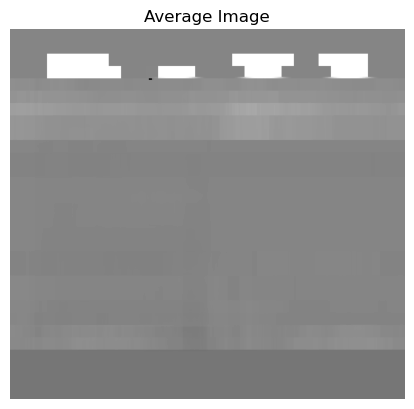

In [16]:
#np mean of states
average_images(rec_state_history)

# Classification Based Approaches

## 1. KNN

We used KNN as an example as to why our agent should not use classification methods using state-action pairs to solve the issue. One issue is KNN's susceptibility to noise. Since there are so many permutations to how a scene could be set depending on where the enemies are relative to the scene, it is hard for us to fully clean our data of noises as it is a large part of the game. 

Another issue for KNN is the curse of dimensionality. This dataset is composed of two numpy arrays: a 3D array that describes the environment and a 1D array that describes the action taken. In many cases in training, our players did drastically different actions at the same observation or the same action at a slightly different observation. Therefore, KNN has difficulties in finding similarities between records. This resulted in our KNN model taking vast amounts of time for training off of a singular isolated run and thus not finishing. We included the code as a large comment since it wil be unable to run in a realistic timeframe due to the sheer size of our data, even when drastically reducing the amount of data used. 

In [8]:
'''
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import pickle
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from gym.wrappers import GrayScaleObservation
import os
import sklearn as sk
from sklearn.pipeline import Pipeline

# Custom imports assuming these are correctly implemented
from playback import get_state_action_pairs

class knn:
    def __init__(self, model = None, n_n= 10):
        self.done = False
        self.name = "KNN"

        #generates a pipeline that scales and decreases dimensions. 
        if model is None:
            pline = Pipeline([('scaler', sk.preprocessing.StandardScaler()), ('pca', sk.decomposition.PCA()), 
                  ('knn', KNeighborsClassifier(n_neighbors= n_n))])
            self.model = pline
        else:
            self.model = model

    def get_action(self, state):
        state = state.flatten().reshape(1, -1)
        return self.model.predict(state)

    def train(self, state_history, action_history):
        self.model.fit(state_history, action_history)
        pickle.dump(self.model, open("knn.p", "wb"))
        print("Training Complete.")

    def evaluate_and_tune(self, features, labels):
        parameters = {
             'n_neighbors': [None, 5, 10, 15]
        }
        cv = 5
        grid_search = GridSearchCV(self.model, parameters, cv=cv, scoring='accuracy', return_train_score=True)
        grid_search.fit(features, labels)

        print('Best Parameters:', grid_search.best_params_)
        return grid_search

def plot_accuracy(grid_search):
    results = grid_search.cv_results_
    plt.figure(figsize=(10, 5))
    plt.title("Training vs Validation Accuracy")
    plt.plot(results['mean_train_score'], label='Train Accuracy')
    plt.plot(results['mean_test_score'], label='Validation Accuracy')
    plt.xlabel('Parameter Combination')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def run_agent(agent):
    env = GrayScaleObservation(gym.make("SuperMarioBros-v3"))
    env.reset()
    done = False
    state_history = []
    action_history = []

    with tqdm(total=100) as pbar:
        while not done:
            state, reward, done, _ = env.step(0)  # Example using a constant action
            action = agent.get_action(state)
            state_history.append(state)
            action_history.append(action)
            pbar.update(1)

    env.close()



if __name__ == "__main__":
    record_path = "recordings"
    
    if not os.path.isdir(record_path):
        print(f"Error: {record_path} is not a valid directory.")
    else:
        rec_state_history, rec_action_history = get_state_action_pairs(2)

        if rec_state_history.ndim == 3:
            nsamples, height, width = rec_state_history.shape
            rec_state_history = rec_state_history.reshape((nsamples, height * width))

        print("Reshaped state history shape:", rec_state_history.shape)

        train_states, test_states, train_actions, test_actions = train_test_split(
            rec_state_history, rec_action_history, test_size=0.2, random_state=42)

        agent = knn()
        agent.train(train_states, train_actions)

        grid_search = agent.evaluate_and_tune(train_states, train_actions)
        plot_accuracy(grid_search)

        run_agent(agent)

'''

'\nimport gym\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score\nimport pickle\nfrom datetime import datetime\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom tqdm import tqdm\nfrom gym.wrappers import GrayScaleObservation\nimport os\nimport sklearn as sk\nfrom sklearn.pipeline import Pipeline\n\n# Custom imports assuming these are correctly implemented\nfrom playback import get_state_action_pairs\n\nclass knn:\n    def __init__(self, model = None, n_n= 10):\n        self.done = False\n        self.name = "KNN"\n\n        #generates a pipeline that scales and decreases dimensions. \n        if model is None:\n            pline = Pipeline([(\'scaler\', sk.preprocessing.StandardScaler()), (\'pca\', sk.decomposition.PCA()), \n                  (\'knn\', KNeighborsClassifier(n_neighbors= n_n))])\n            self.model = pline\n        else:\n            self.model = model\n\n    def get_action

# 2. Decision Trees
We also used a decision tree to further demonstrate how classification using state-action pairs was inappropriate for our problem. Our data is filled with many occurrences of the same observation but slightly different actions in reaction to the same environment. 
In one run, the same person could jump at a frame earlier and thus not jump at the consequent frame or the same person could jump
at the consequent frame and not do anything in the frame prior. This makes it difficult for the agent to draw similarities
between runs, making it hard for the tree to fit an action to a specific state. 

In [2]:
#imports for decision trees
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import pickle
from datetime import datetime
from tqdm import tqdm
from gym.wrappers import GrayScaleObservation
import os
from sklearn import tree
# Custom imports
from playback import get_state_action_pairs

In [3]:
# Decision Tree Class
class DecisionTree:
    def __init__(self, model = None, max_d = 10, dummy = False):
        self.done = False
        self.name = "decision_tree"
        if model is None:
            self.model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_d)
        else:
            self.model = model

    def get_action(self, state):
        state = state.flatten().reshape(1, -1)
        return self.model.predict(state)

    def train(self, state_history, action_history):
        self.model.fit(state_history, action_history)
        pickle.dump(self.model, open("decision_tree_model.p", "wb"))
        print("Training Complete.")

    def evaluate_and_tune(self, features, labels):
        parameters = {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [None, 10, 20, 30]
        }
        cv = 5
        grid_search = GridSearchCV(self.model, parameters, cv=cv, scoring='accuracy', return_train_score=True)
        grid_search.fit(features, labels)

        print('Best Parameters:', grid_search.best_params_)
        return grid_search


In [4]:
def run_agent(agent):
    env = GrayScaleObservation(gym.make("SuperMarioBros-v3"))
    env.reset()
    done = False
    state_history = []
    action_history = []

    with tqdm(total=100) as pbar:
        while not done:
            state, reward, done, _ = env.step(0)  # Example using a constant action
            action = agent.get_action(state)
            state_history.append(state)
            action_history.append(action)
            pbar.update(1)

    env.close()

In [5]:
record_path = "recordings"

if not os.path.isdir(record_path):
    print(f"Error: {record_path} is not a valid directory.")
else:
    rec_state_history, rec_action_history = get_state_action_pairs(2)

    if rec_state_history.ndim == 3:
        nsamples, height, width = rec_state_history.shape
        rec_state_history = rec_state_history.reshape((nsamples, height * width))

    print("Reshaped state history shape:", rec_state_history.shape)

    train_states, test_states, train_actions, test_actions = train_test_split(
        rec_state_history, rec_action_history, test_size=0.2, random_state=42)

    agent = DecisionTree()
    agent.train(train_states, train_actions)

    grid_search = agent.evaluate_and_tune(train_states, train_actions)


Adding  imitation_mario_rec_carson_032124_145619.npz
Adding  imitation_mario_rec_carson_032124_145652.npz
Reshaped state history shape: (6707, 61440)
Training Complete.


/home/mathew/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'criterion': 'log_loss', 'max_depth': 30}


In [6]:
run_agent(agent)

/home/mathew/miniconda3/lib/python3.11/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/mathew/miniconda3/lib/python3.11/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|                                                   | 0/100 [00:00<?, ?it/s]/home/mathew/miniconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
28873

Text(0, 0.5, 'Accuracy')

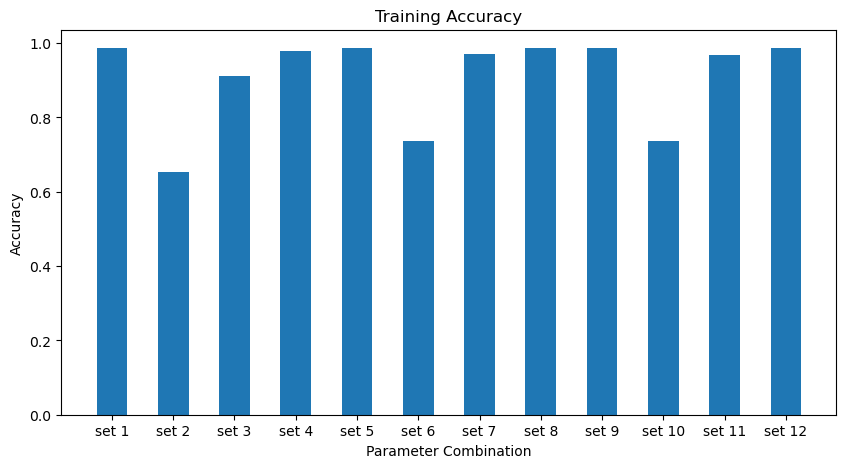

In [7]:
results = grid_search.cv_results_
sets = ['set 1', 'set 2', 'set 3', 'set 4', 'set 5' , 'set 6', 'set 7', 'set 8', 'set 9', 'set 10', 'set 11', 'set 12']
plt.figure(figsize=(10, 5))
plt.title("Training Accuracy")
plt.bar(sets, results['mean_train_score'], width= 0.5)
plt.xlabel('Parameter Combination')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

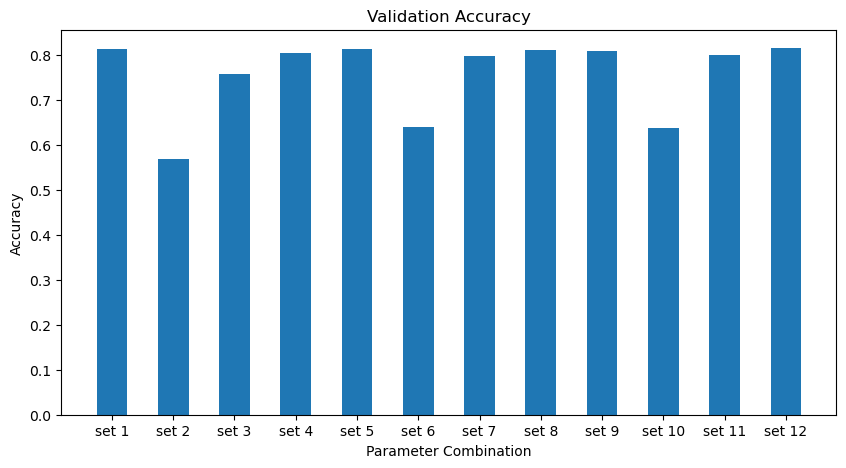

In [8]:
plt.figure(figsize=(10, 5))
plt.title("Validation Accuracy")
plt.bar(sets, results['mean_test_score'], width= 0.5)
plt.xlabel('Parameter Combination')
plt.ylabel('Accuracy')

In [9]:

print('combinations:      \nset 1: gini + none      \nset 2: gini + 10      \nset 3: gini + 20 \nset 4: gini+ 30 \nset 5: entropy + none \nset 6: entropy + 10 \nset 7: entropy + 20 \nset 8: entropy + 30 \nset 9: log loss + none \nset 10: log loss + 10 \nset 11: log loss + 20 \nset 12: log loss + 30 ')

combinations:      
set 1: gini + none      
set 2: gini + 10      
set 3: gini + 20 
set 4: gini+ 30 
set 5: entropy + none 
set 6: entropy + 10 
set 7: entropy + 20 
set 8: entropy + 30 
set 9: log loss + none 
set 10: log loss + 10 
set 11: log loss + 20 
set 12: log loss + 30 


In [ ]:
#save the model


# 3. ADABoosting
We used ADABoosting as an example as to why our agent should not use classification methods using state-action pairs to play super mario. Though the accuracy of the boosting model is generally higher than techniques alone, in our case, since we are using ensembling in a supervised learning way based on the decision tree stump model, the ensemble booster model accuracy is ____. Since the goal of our classification is to classify in a way that allows the model to beat the super mario game, the application of ensembling wouldn't be the best as it would base the action it takes strictly on the states ran through by a mario play-through done by the user, which could be susceptible to faulty playthroughs. If we were to apply an RL agent on the other hand which creates policies on the premise of maximizing rewards as our model for ADABoosting, it would likely be a good approach as the accuracy would be increased substantially.

In [10]:
#imports
import gym
from nes_py.wrappers import JoypadSpace
from nes_py.app.play_human import play_human
from gym.wrappers.gray_scale_observation import GrayScaleObservation
import cv2
import numpy as np
from datetime import datetime
from sklearn.ensemble import *
import pickle
from playback import get_state_action_pairs
from sklearn.model_selection import *

In [11]:
# ADABoost
class boosting_agent:
    def __init__(self, model = None, n_estimators = 50):
        self.done = False
        self.name = "boosting_agent"
        if model is None:
            self.model = AdaBoostClassifier(n_estimators = n_estimators)
        else:
            self.model = model

    def get_action(self, state):
        state = state.flatten().reshape(1, -1)
        return self.model.predict(state)

    def train(self, state_history, action_history):
        self.model.fit(state_history, action_history)
        pickle.dump(self.model, open("booster_model.p", "wb"))
        print("Training Complete.")

    def evaluate_and_tune(self, features, labels):
        parameters = {
            'n_estimators': [40, 50, 60],
            'learning_rate': [0.8, 1.0, 1.2]
        }
        cv = 5
        grid_search = GridSearchCV(self.model, parameters, cv=cv, scoring='accuracy', return_train_score=True)
        grid_search.fit(features, labels)

        print('Best Parameters:', grid_search.best_params_)
        return grid_search


In [12]:
def run_agent(agent):
    env = GrayScaleObservation(gym.make("SuperMarioBros-v3"))
    env.reset()
    done = False
    state_history = []
    action_history = []

    with tqdm(total=100) as pbar:
        while not done:
            state, reward, done, _ = env.step(0)  # Example using a constant action
            action = agent.get_action(state)
            state_history.append(state)
            action_history.append(action)
            pbar.update(1)

    env.close()

In [13]:
record_path = "recordings"

if not os.path.isdir(record_path):
    print(f"Error: {record_path} is not a valid directory.")
else:
    rec_state_history, rec_action_history = get_state_action_pairs(2)

    if rec_state_history.ndim == 3:
        nsamples, height, width = rec_state_history.shape
        rec_state_history = rec_state_history.reshape((nsamples, height * width))

    print("Reshaped state history shape:", rec_state_history.shape)

    train_states, test_states, train_actions, test_actions = train_test_split(
        rec_state_history, rec_action_history, test_size=0.2, random_state=42)

    agent = boosting_agent()
    agent.train(train_states, train_actions)

    grid_search = agent.evaluate_and_tune(train_states, train_actions)


Adding  imitation_mario_rec_carson_032124_145619.npz
Adding  imitation_mario_rec_carson_032124_145652.npz
Reshaped state history shape: (6707, 61440)
Training Complete.


/home/mathew/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'learning_rate': 1.0, 'n_estimators': 40}


In [14]:
run_agent(agent)

/home/mathew/miniconda3/lib/python3.11/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/mathew/miniconda3/lib/python3.11/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|                                                   | 0/100 [00:00<?, ?it/s]/home/mathew/miniconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
28873

Text(0, 0.5, 'Accuracy')

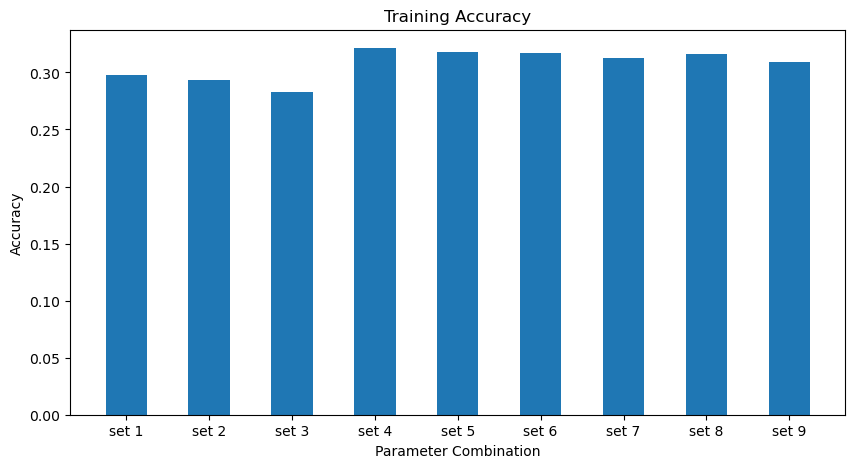

In [15]:
results = grid_search.cv_results_
sets = ['set 1', 'set 2', 'set 3', 'set 4', 'set 5' , 'set 6', 'set 7', 'set 8', 'set 9']
plt.figure(figsize=(10, 5))
plt.title("Training Accuracy")
plt.bar(sets, results['mean_train_score'], width= 0.5)
plt.xlabel('Parameter Combination')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

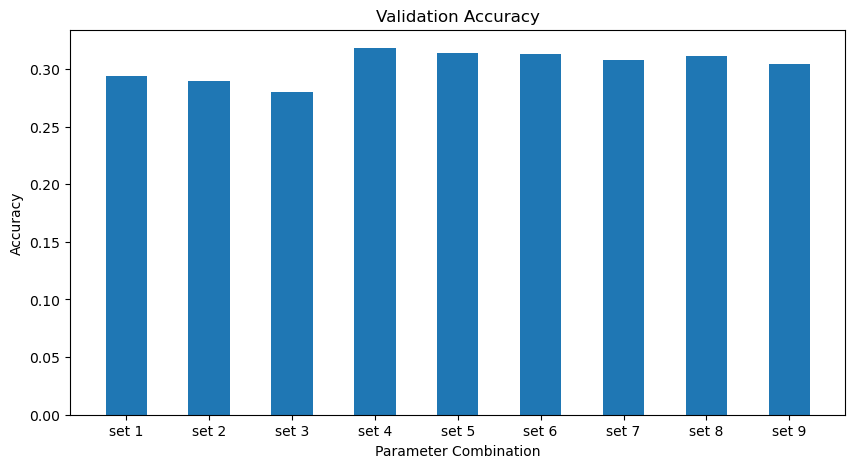

In [16]:
plt.figure(figsize=(10, 5))
plt.title("Validation Accuracy")
plt.bar(sets, results['mean_test_score'], width= 0.5)
plt.xlabel('Parameter Combination')
plt.ylabel('Accuracy')

In [22]:
print('combinations (n estimators, learning rate) :\nset 1: (40, 0.8) \nset 2: (40, 1.0) \nset 3: (40, 1.2) \nset 4: (50, 0.8) \nset 5 (50, 1.0) \nset 6 (50, 1.2) \nset 7 (60, 0.8) \nset 8(60, 1.0) \nset 9 (60, 1.2)')

combinations (n estimators, learning rate) :
set 1: (40, 0.8) 
set 2: (40, 1.0) 
set 3: (40, 1.2) 
set 4: (50, 0.8) 
set 5 (50, 1.0) 
set 6 (50, 1.2) 
set 7 (60, 0.8) 
set 8(60, 1.0) 
set 9 (60, 1.2)


In [21]:
#save boosting agent
pickle.dump(agent, open("BoostingAgent.p", "wb"))

# 4. CNN

Process: Our process involved splitting the dataset into training and validation sets using a 80-20 ratio. We tested every combination of kernel size and activation function for 4 epochs. Once we decided not to vary our batch size we kept it constant at 32. We then recorded the training histories which included the training and validation accuracies for each combination of hyperparameters.

Conclusion: Based on hyperparameter tuning we found that the combination of a kernel size with (3,3) and the tanh activation function seemed to be the most effective as evidenced by the training and validation accuracy.

Further steps: In order to further tune our hyperparameters to make more accurate predictions we could vary the number of our convolutional layers. Since increasing the number of convolutional layers may allow our model to distinguish between more complex representations, we may be able to improve our performance. We could also test different learning rates to optimize convergence.




In [ ]:
import gym_super_mario_bros
import gym
import nes_py
from nes_py.wrappers import JoypadSpace
from nes_py.app.play_human import play_human
from gym.wrappers.gray_scale_observation import GrayScaleObservation
import cv2
import numpy as np
import sys
from datetime import datetime
import argparse
import pickle
from playback import get_state_action_pairs 
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

The below code converts our game space from rgb to grayscale. Eliminate unecessary action remaps our actionspace from 0->7 as this is what our action input data is looking for. Each number responds to a specific action such as 128 occurs when the user click d and it causes Mario to move forward.

In [ ]:

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def eliminate_unnecessary_action(data):
    action_space = data
    action_map = {
        64: 0,
        65: 1,
        66: 2,
        67: 3,
        128: 4,
        129: 5,
        130: 6,
        131: 7
    }
    
    action_space = np.array([action_map.get(action, 0) for action in action_space])
    return action_space

The code below defines a specific CNN architecture. It is using TensorFlow's keras library.

In [ ]:
# Create CNN model with specific layers, some values given from CNN tutorial with tensorflow
def create_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

Kernel Sizes: We tested three different kernel sizes ((3,3),(5,5),(7,7)). As a smaller kernel sizes focus on smaller regions of our input image, we expected the larger kernel sizes to be more effective as they would capture a wider range of information from our input image.

Activation Functions: We tested three different activation functions (Rectified Linear Unit, Hyperbolic Tangent, and Sigmoid).
As relu (Rectified Linear Unit), is known for its effectiveness with regards to deep learning models, we expected it to perform the best.

Note: Tried batch sizes but didn't feel it had a significant enough change in our accuracy. Now we set our batch size to 32.

In [ ]:
def hyperparameter_tuning(state_history, action_history):
    kernel_sizes = [(3, 3), (5, 5),(7,7)]
    activation_functions = ['relu','tanh','sigmoid']
    #batch_sizes = [32, 64, 128]

    training_histories = []
    accuracies = []

    for kernel_size in kernel_sizes:
        for activation_function in activation_functions:
            print(f"training with kernel size: {kernel_size} and activation function: {activation_function}")
            train_a, test_a, train_b, test_b = train_test_split(state_history, action_history, test_size=0.2, random_state=42)
            train_a = np.expand_dims(train_a, axis=-1)
            test_a = np.expand_dims(test_a, axis=-1)
            
            train_a = train_a / 255.0
            test_a = test_a / 255.0

            model = create_cnn(input_shape=(state_history.shape[1], state_history.shape[2], 1), num_classes=np.max(action_history) + 1)
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            history = model.fit(train_a, train_b, epochs=4, batch_size=32, validation_data=(test_a, test_b))

            training_histories.append(history)
            accuracies.append(history.history['val_accuracy'][-1])

The code below graphs both the training accuracy and the validation accuracy over a specified amount of epochs. The graph line colors correspond to the specific combination of kernel sizes and and activation functions. The same combination color is used for the training accuracy and the validation accuracy.

In [ ]:
    plt.figure(figsize=(10, 12))
    colors = plt.cm.tab10.colors[:len(kernel_sizes) * len(activation_functions)]

    plt.subplot(2, 1, 1)
    for i, kernel_size in enumerate(kernel_sizes):
        for j, activation_function in enumerate(activation_functions):
            plt.plot(range(1, 5), training_histories[i*len(activation_functions)+j].history['accuracy'], label=f'kernel size:{kernel_size}, activation:{activation_function}')

    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Training Accuracy')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=3,fontsize='small')

    plt.subplot(2, 1, 2)
    for i, kernel_size in enumerate(kernel_sizes):
        for j, activation_function in enumerate(activation_functions):
            color = colors[i*len(activation_functions)+j
            plt.plot(range(1, 5), training_histories[i*len(activation_functions)+j].history['val_accuracy'], label=f'kernel size: {kernel_size}, activation:{activation_function}', color=color)

    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('validation accuracy')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fontsize='small')

    plt.tight_layout()
    plt.show()

    print("Validation Accuracies:")
    for i, kernel_size in enumerate(kernel_sizes):
        for j, activation_function in enumerate(activation_functions):
            print(f'kernel size:{kernel_size}, activation:{activation_function}: {accuracies[i*len(activation_functions)+j]}')


Define the CNN Agent.

In [ ]:
class CNNAgent:
    def __init__(self, model=None, state_history=None, action_history=None):
        self.done = False
        self.name = "cnn_agent"
        if model is None:
            num_classes = np.max(action_history) + 1
            self.model = create_cnn(input_shape=(state_history.shape[1], state_history.shape[2], 1), num_classes=num_classes)
        else:
            self.model = model

    def get_action(self, state):
        state = np.expand_dims(state, axis=0)
        state = np.expand_dims(state, axis=-1)
        return np.argmax(self.model.predict(state))
        
    def train(self, state_history, action_history):

        print("Training...")
        train_a, test_a, train_b, test_b = train_test_split(state_history, action_history, test_size=0.2, random_state=42)
        train_a = np.expand_dims(train_a, axis=-1)
        test_a = np.expand_dims(test_a, axis=-1)
        train_a = train_a / 255.0
        test_a = test_a / 255.0
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = self.model.fit(train_a, train_b, epochs=1, validation_data=(test_a, test_b))
        self.model.save("models/cnn_model.h5")
        print("Training complete.")

        #Graph validation and training accuracy as epochs increase
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()
        pass


In [ ]:
def run_agent(agent):

    env = GrayScaleObservation(gym_super_mario_bros.make("SuperMarioBros-v3"))
    env.reset()

    action_history = []
    state_history = []
    reward_history = []

    action = [0]
    done = False
    while not done:
        state, reward, done, _ = env.step(action)
        action_history.append(action)
        state_history.append(rgb2gray(state))
        reward_history.append(reward)
        action = agent.get_action(state)
        if done:
            print("Done")
            break
        if agent.done:
            print("Agent done")
            done = True
            break

    day_time = datetime.today().strftime("%m%d%y_%H%M%S")
    np.savez(f".\\agent_recordings\\{agent.name}_{day_time}", np.array(state_history), np.array(action_history), np.array(reward_history))
    print("Recording saved")
    env.close()
    cv2.destroyAllWindows()
    print("Windows closed")


In [ ]:

rec_state_history, rec_action_history = get_state_action_pairs(2)
rec_action_history = eliminate_unnecessary_action(rec_action_history)
agent = CNNAgent(model=None, state_history=rec_state_history, action_history=rec_action_history)
hyperparameter_tuning(rec_state_history, rec_action_history)

# 4. Proximal Policy Optimization using Stable Baselines 3
After finding that most classification approaches failed to yield useful results, we decided to consult the literature for a more appropriate approach. Promimal Policy Optimization (https://arxiv.org/pdf/1707.06347.pdf) is a reinforcement learning approach developed by OpenAI in 2017. Since then it has become a standard approach for reinforcement learning tasks. After doing some research online, we were able to find a utility wrapper for the SuperMarioBros gym environment. This wrapper accesses the RAM of the NES simulator directly, exposing the location of Mario and the scene features directly. This makes it easier for PPO to learn a performant policy more quickly as it doesn't need to learn the mapping from the image space to semanticly meaningful features.



In [1]:
# All necessary imports
from nes_py.wrappers import JoypadSpace
import gym 
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, RIGHT_ONLY 

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnv, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
import os
import time
import matplotlib.pyplot as plt
from datetime import datetime
from gym_utils import SMBRamWrapper
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

%matplotlib inline

### Defining Callback and Helper Functions
The logging callback class is used to populate the score/time_step lists for later display.  
The linear schedule is derived from the stablebaselines documentation, and is considered a standard approach for PPO.

In [2]:
class EvaluationCallback(BaseCallback):

    def __init__(self, check_freq, env_wrap, starting_steps=0, verbose=1):
        super(EvaluationCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.starting_steps = starting_steps
        self.evaluations = []

    def _init_callback(self):
        self.env_wrap = self.model.get_env()
        print("Initialized Callback")

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            eval = evaluate_policy(self.model, self.env_wrap, n_eval_episodes=1, deterministic=True, render=False, return_episode_rewards=False)
            self.evaluations.append(eval[0])
        return True
    
# Linear learning rate schedule
# https://stable-baselines3.readthedocs.io/en/master/guide/examples.html#learning-rate-schedule
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

In [3]:
# Create the environment
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v3')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
x0 = 0
x1 = 16
y0 = 0
y1 = 13
n_stack = 4
n_skip = 4
env_wrap = SMBRamWrapper(env, [x0, x1, y0, y1], n_stack=n_stack, n_skip=n_skip)
env_wrap = Monitor(env_wrap)
env_wrap = DummyVecEnv([lambda: env_wrap])


In [4]:
day_time = datetime.today().strftime("%m%d%y_%H%M%S")
MODEL_DIR = './models/PPO_' + day_time

In [ ]:
# Hyperparameters to tune on
batch_sizes = [16,32,64]
n_epochs = [8,10,12]
gammas = [0.8,0.9,0.99]

models = []
evals = []
for batch_size in batch_sizes:
    for n_epoch in n_epochs:
        for gamma in gammas:
            print("Training bs: ", batch_size, " n_e: ", n_epoch, " gamma: ", gamma)
            model = PPO('MlpPolicy', env_wrap, verbose=0, learning_rate=linear_schedule(3e-4), batch_size=batch_size,n_epochs=n_epoch,gamma=gamma) 
            model.learn(total_timesteps=1e2)
            eval = evaluate_policy(model, env_wrap, n_eval_episodes=1, deterministic=True, render=False, return_episode_rewards=False)
            models.append(model)
            evals.append(eval)
            print("Evaluation performance: ", eval)
            

Training bs:  16  n_e:  8  gamma:  0.8
Evaluation performance:  (232.0, 0.0)
Training bs:  16  n_e:  8  gamma:  0.9
Evaluation performance:  (232.0, 0.0)
Training bs:  16  n_e:  8  gamma:  0.99
Evaluation performance:  (232.0, 0.0)
Training bs:  16  n_e:  10  gamma:  0.8
Evaluation performance:  (252.0, 0.0)
Training bs:  16  n_e:  10  gamma:  0.9
Evaluation performance:  (232.0, 0.0)
Training bs:  16  n_e:  10  gamma:  0.99
Evaluation performance:  (-415.0, 0.0)
Training bs:  16  n_e:  12  gamma:  0.8
Evaluation performance:  (232.0, 0.0)
Training bs:  16  n_e:  12  gamma:  0.9
Evaluation performance:  (-415.0, 0.0)
Training bs:  16  n_e:  12  gamma:  0.99
Evaluation performance:  (252.0, 0.0)
Training bs:  32  n_e:  8  gamma:  0.8
Evaluation performance:  (-455.0, 0.0)
Training bs:  32  n_e:  8  gamma:  0.9


In [8]:
1e3

1000.0

In [ ]:
# #Training all of the models
# t_start = time.time()
# model.learn(total_timesteps=10e3, callback=callback,progress_bar=True)
# t_elapsed = time.time() - t_start
# print('Wall time: {} s'.format(round(t_elapsed, 2)))
# # Save model
# model_path = os.path.join(MODEL_DIR)
# model.save(model_path)

In [ ]:
# evaluate the model
evaluate_policy(model, env_wrap, n_eval_episodes=1, deterministic=True, render=False, return_episode_rewards=False)
plt.figure()
plt.plot(callback.evaluations)
plt.show()

In [ ]:
episode = 1

for episode in range(1, episode+1):
    states = env_wrap.reset()
    done = False
    score = 0
    
    while not done:
        env_wrap.render()
        action, _ = model.predict(states, deterministic=True)
        states, reward, done, info = env_wrap.step(action)
        score += reward
        time.sleep(0.01)
    print('Episode:{} Score:{}'.format(episode, score))

In [ ]:
env.close()

In [ ]:
callback.evaluations